# Understanding recurrent neural networks

This notebook is based on code samples found in Chapter 6, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) and hosted on https://github.com/fchollet/deep-learning-with-python-notebooks. 

Note that the original text features far more content, in particular further explanations and figures.


In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [4]:
tf.keras.__version__

'2.3.0-tf'


## A first recurrent layer in Keras

The `SimpleRNN` layer contains very simple RNN cells that behave just like a recurrent dense layer.


In [5]:
from tensorflow.keras.layers import SimpleRNN

In past notebooks we have seen that Keras' `Dense` layer takes as input batches of elements. In contrast, `SimpleRNN` processes batches of sequences. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, 
input_features)`.


Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes:

1. Return either full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
2. Return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). 

These two modes are controlled by the `return_sequences` constructor 
argument:

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [7]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to **stack several recurrent layers** one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [8]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use a model with RNN on the IMDB movie review classification problem. First, let's preprocess the data:

In [10]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [11]:
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 27s 171ms/step - loss: 0.5700 - acc: 0.7019 - val_loss: 0.4351 - val_acc: 0.8052
Epoch 2/10
157/157 [==============================] - 26s 167ms/step - loss: 0.3418 - acc: 0.8625 - val_loss: 0.4065 - val_acc: 0.8150
Epoch 3/10
157/157 [==============================] - 26s 166ms/step - loss: 0.2806 - acc: 0.8905 - val_loss: 0.4057 - val_acc: 0.8170
Epoch 4/10
157/157 [==============================] - 26s 167ms/step - loss: 0.2303 - acc: 0.9111 - val_loss: 0.3673 - val_acc: 0.8476
Epoch 5/10
157/157 [==============================] - 26s 166ms/step - loss: 0.2035 - acc: 0.9247 - val_loss: 0.3361 - val_acc: 0.8694
Epoch 6/10
157/157 [==============================] - 26s 167ms/step - loss: 0.1862 - acc: 0.9322 - val_loss: 0.3535 - val_acc: 0.8680
Epoch 7/10
157/157 [==============================] - 30s 190ms/step - loss: 0.1468 - acc: 0.9488 - val_loss: 0.4300 - val_acc: 0.8636
Epoch 8/10
157/157 [==============================] - 2

Let's display the training and validation loss and accuracy:

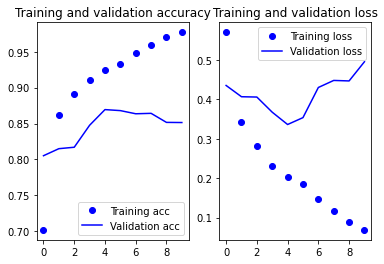

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As a reminder, in chapter 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.

## A concrete LSTM example in Keras

`SimpleRNN` is not very good at capturing long-distance dependencies. Both `LSTM` and `GRU` are explicitly designed to handle this problem.

Below we will repeat the same model using `LSTM`, using Keras' defaults for most options.



Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.


In [13]:
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 4s 24ms/step - loss: 0.5020 - acc: 0.7602 - val_loss: 0.4912 - val_acc: 0.7764
Epoch 2/10
157/157 [==============================] - 3s 22ms/step - loss: 0.2982 - acc: 0.8839 - val_loss: 0.2950 - val_acc: 0.8808
Epoch 3/10
157/157 [==============================] - 4s 23ms/step - loss: 0.2312 - acc: 0.9126 - val_loss: 0.2752 - val_acc: 0.8854
Epoch 4/10
157/157 [==============================] - 4s 23ms/step - loss: 0.2167 - acc: 0.9238 - val_loss: 0.3021 - val_acc: 0.8860
Epoch 5/10
157/157 [==============================] - 4s 23ms/step - loss: 0.1795 - acc: 0.9352 - val_loss: 0.3057 - val_acc: 0.8774
Epoch 6/10
157/157 [==============================] - 3s 22ms/step - loss: 0.1590 - acc: 0.9441 - val_loss: 0.2937 - val_acc: 0.8908
Epoch 7/10
157/157 [==============================] - 3s 22ms/step - loss: 0.1478 - acc: 0.9480 - val_loss: 0.3242 - val_acc: 0.8722
Epoch 8/10
157/157 [==============================] - 3s 22ms/step - 

If your computer has a GPU you will probably observe that training is much faster when using LSTM. This is because Tensorflow-Keras has libraries that optimise the implementation of LSTMs for your GPU.

If the code above doesn't work and it reports an error of the form `Fail to find the dnn implementation`, you may need to update `cudnn` by typing the following command in a terminal prompt:
```
$ conda install -c anaconda cudnn
```

See: https://github.com/tensorflow/tensorflow/issues/36508

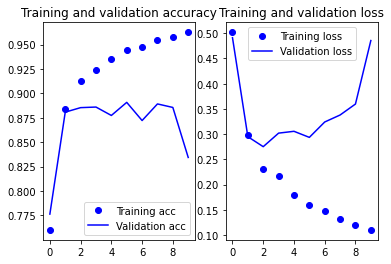

In [14]:
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Now the validation accuracy is much better.